# **Football players pricing**

**Author**: Blibeche Farès

**Date**: January, 2026

**Objective** : To price correctly football players using known informations about their release clauses, performance, physical features ...

Basically, we want to predict **'value_euro'**

## 1. Library import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
# Function to plot the coefficients of the regressions

# Code fully generated by GPT-4
def plot_coef(coef, x_length = 10, y_length = 10) :
    # Sort the coefficients by their absolute values
    sorted_coef = coef.abs().sort_values()

    # Get the original coefficients for coloring
    original_sorted_coef = coef.loc[sorted_coef.index]

    # Create a scatter plot with bars
    plt.figure(figsize=(x_length, y_length))

    # Plot positive coefficients in blue, negative coefficients in red, and near-zero coefficients in grey
    colors = [
        'grey' if abs(coef) < 1e-08 else 'blue' if coef > 0 else 'red'
        for coef in original_sorted_coef
    ]

    plt.scatter(sorted_coef.values, sorted_coef.index, color=colors,  zorder = 5)

    # Plot lines from the origin to the dots
    for i in range(len(sorted_coef)):
        plt.plot([0, sorted_coef.values[i]], [i, i], color='skyblue', lw = 2)

    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Regression Coefficients (Absolute Values)')

    plt.show()


## 2. Data import

Detailed information on approximately 17,000 FIFA football players scraped from SoFIFA.com (season 2018-2019). 

Source : https://www.kaggle.com/datasets/maso0dahmed/football-players-data

In [3]:
RAWdf = pd.read_csv("fifa_players.csv")

display(RAWdf)

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17949,R. McKenzie,Rory McKenzie,10/7/1993,25,175.26,74.8,"RM,CAM,CM",Scotland,67,70,...,54,69,41,60,64,63,56,40,20,18
17950,M. Sipľak,Michal Sipľak,2/2/1996,23,182.88,79.8,LB,Slovakia,59,67,...,22,62,55,42,39,32,52,53,64,60
17951,J. Bekkema,Jan Bekkema,4/9/1996,22,185.42,89.8,GK,Netherlands,59,67,...,9,27,10,5,25,16,47,9,12,13
17952,A. Al Yami,Abdulrahman Al Yami,6/19/1997,21,175.26,64.9,"ST,LM",Saudi Arabia,59,71,...,58,38,15,54,52,50,53,16,18,17


Checking if data look consistent by checking if $birth + age \in \{2018, 2019\}$

In [4]:
set(RAWdf['birth_date'].astype(str).str[-4:].astype(int) + RAWdf['age'])

{2018, 2019}

## 3. Data cleaning

### 3.1. Select data & data binarization 

We write functions change categorial data in binary data faster.
We can reuse thoses functions in many datasets.

In [5]:
def fill_with_None(data, column):
    return data[column].where(data[column].notna(), None)

def from_category_to_binary_columns(data, column):
    data[column] = fill_with_None(data, column)
    
    list_of_categories = set(data[column])
    for cat in list_of_categories:
        data[column + str(cat)] = (data[column] == cat).astype(int)
    
    data.drop(columns=[column], inplace=True)

def categories_to_binary_adapted_for_positions(data, column):
    data[column] = fill_with_None(data, column)

    list_of_categories = set([x for sublist in data[column].astype(str).str.split(",") for x in sublist])
    for cat in list_of_categories:
        data[column + str(cat)] = data[column].str.contains(cat, na=False).astype(int)

    data.drop(columns=[column], inplace=True)

def date_separator(data, column, sep='/'):

    data['day_' + column] = data[column].astype(str).str.split(sep).str[0]
    data['month_' + column] = data[column].astype(str).str.split(sep).str[1]
    data['year_' + column] = data[column].astype(str).str.split(sep).str[2]

    data.drop(columns=[column], inplace=True)


Let's work with a new dataframe : df

In [6]:
df = RAWdf.copy()

df.drop(columns=['name', 'full_name', 'national_jersey_number', 'body_type', 'national_rating'], inplace=True)

from_category_to_binary_columns(df, 'nationality')
from_category_to_binary_columns(df, 'preferred_foot')
from_category_to_binary_columns(df, 'national_team')

categories_to_binary_adapted_for_positions(df, 'positions')
categories_to_binary_adapted_for_positions(df, 'national_team_position')

date_separator(df, 'birth_date')

df = df[df['value_euro'].notna()]


display(df)

C:\Users\fares\AppData\Local\Temp\ipykernel_2740\1912689205.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column + str(cat)] = (data[column] == cat).astype(int)
C:\Users\fares\AppData\Local\Temp\ipykernel_2740\1912689205.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column + str(cat)] = (data[column] == cat).astype(int)
C:\Users\fares\AppData\Local\Temp\ipykernel_2740\1912689205.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

,age,height_cm,weight_kgs,overall_rating,potential,value_euro,wage_euro,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),...,national_team_positionLDM,national_team_positionLCB,national_team_positionNone,national_team_positionRB,national_team_positionLS,national_team_positionCAM,national_team_positionLB,day_birth_date,month_birth_date,year_birth_date
0,31,170.18,72.1,94,94,110500000.0,565000.0,5,4,4,...,0,0,0,0,0,0,0,6,24,1987
1,27,154.94,76.2,88,89,69500000.0,205000.0,3,5,4,...,0,0,0,0,0,1,0,2,14,1992
2,25,190.50,83.9,88,91,73000000.0,255000.0,4,4,5,...,0,0,0,0,0,0,0,3,15,1993
3,27,162.56,59.0,88,88,62000000.0,165000.0,3,4,4,...,0,0,0,0,0,0,0,6,4,1991
4,27,187.96,88.9,88,91,60000000.0,135000.0,3,3,2,...,0,0,0,0,0,0,0,6,20,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17949,25,175.26,74.8,67,70,975000.0,3000.0,1,3,3,...,0,0,0,0,0,0,0,10,7,1993
17950,23,182.88,79.8,59,67,190000.0,1000.0,1,3,2,...,0,0,0,0,0,0,0,2,2,1996
17951,22,185.42,89.8,59,67,170000.0,1000.0,1,1,1,...,0,0,0,0,0,0,0,4,9,1996
17952,21,175.26,64.9,59,71,280000.0,4000.0,1,4,3,...,0,0,0,0,0,0,0,6,19,1997


### 3.2. Feature engineering

In [7]:
def remove_all_notna(data, list_col):
    for col in list_col:
        data = data[data[col].notna()]
    return data

def apply_usual_functions(data, column):
    
    data[column] = df[column].astype(float)
    data[column + "_squared"] = data[column] ** 2
    data[column + "_sqrt"] = np.sqrt(data[column])
    data[column + "_log"] = np.log10(data[column])

In [8]:
list_cols_to_transform = ['age', 'height_cm', 'weight_kgs', 'overall_rating', 'potential', 'wage_euro', 'international_reputation(1-5)', 'weak_foot(1-5)', 'skill_moves(1-5)', 'release_clause_euro', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'freekick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'composure', 'marking', 'standing_tackle', 'sliding_tackle']

df = remove_all_notna(df, df.columns)

for col in list_cols_to_transform:
    apply_usual_functions(df, col)

display(df)

C:\Users\fares\AppData\Local\Temp\ipykernel_2740\496636918.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column + "_squared"] = data[column] ** 2
C:\Users\fares\AppData\Local\Temp\ipykernel_2740\496636918.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[column + "_sqrt"] = np.sqrt(data[column])
C:\Users\fares\AppData\Local\Temp\ipykernel_2740\496636918.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

,age,height_cm,weight_kgs,overall_rating,potential,value_euro,wage_euro,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),...,composure_log,marking_squared,marking_sqrt,marking_log,standing_tackle_squared,standing_tackle_sqrt,standing_tackle_log,sliding_tackle_squared,sliding_tackle_sqrt,sliding_tackle_log
0,31.0,170.18,72.1,94.0,94.0,110500000.0,565000.0,5.0,4.0,4.0,...,1.982271,1089.0,5.744563,1.518514,784.0,5.291503,1.447158,676.0,5.099020,1.414973
1,27.0,154.94,76.2,88.0,89.0,69500000.0,205000.0,3.0,5.0,4.0,...,1.944483,3481.0,7.681146,1.770852,3249.0,7.549834,1.755875,484.0,4.690416,1.342423
2,25.0,190.50,83.9,88.0,91.0,73000000.0,255000.0,4.0,4.0,5.0,...,1.939519,3969.0,7.937254,1.799341,4489.0,8.185353,1.826075,4489.0,8.185353,1.826075
3,27.0,162.56,59.0,88.0,88.0,62000000.0,165000.0,3.0,4.0,4.0,...,1.919078,2601.0,7.141428,1.707570,576.0,4.898979,1.380211,484.0,4.690416,1.342423
4,27.0,187.96,88.9,88.0,91.0,60000000.0,135000.0,3.0,3.0,2.0,...,1.903090,8281.0,9.539392,1.959041,7744.0,9.380832,1.944483,7569.0,9.327379,1.939519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17949,25.0,175.26,74.8,67.0,70.0,975000.0,3000.0,1.0,3.0,3.0,...,1.748188,1600.0,6.324555,1.602060,400.0,4.472136,1.301030,324.0,4.242641,1.255273
17950,23.0,182.88,79.8,59.0,67.0,190000.0,1000.0,1.0,3.0,2.0,...,1.716003,2809.0,7.280110,1.724276,4096.0,8.000000,1.806180,3600.0,7.745967,1.778151
17951,22.0,185.42,89.8,59.0,67.0,170000.0,1000.0,1.0,1.0,1.0,...,1.672098,81.0,3.000000,0.954243,144.0,3.464102,1.079181,169.0,3.605551,1.113943
17952,21.0,175.26,64.9,59.0,71.0,280000.0,4000.0,1.0,4.0,3.0,...,1.724276,256.0,4.000000,1.204120,324.0,4.242641,1.255273,289.0,4.123106,1.230449


### 3.3. Monovariate description

Text(0.5, 0, 'Value in euro')

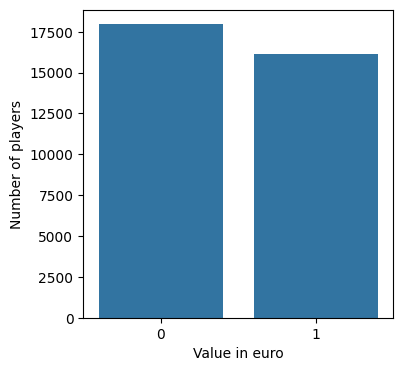

In [9]:
# Data lost
plt.figure(figsize = (4, 4))
sns.barplot([len(RAWdf), len(df)])
plt.ylabel('Number of players')
plt.xlabel('Value in euro')

Text(0.5, 0, 'Value in euro')

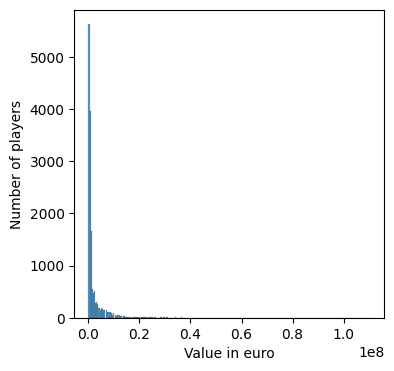

In [10]:
# Predicted variable
plt.figure(figsize = (4, 4))
sns.histplot(df['value_euro'])
plt.ylabel('Number of players')
plt.xlabel('Value in euro')

C:\Users\fares\AppData\Local\Temp\ipykernel_2740\147476750.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['log_value_euro'] = np.log10(df['value_euro'])


Text(0.5, 0, 'Log value')

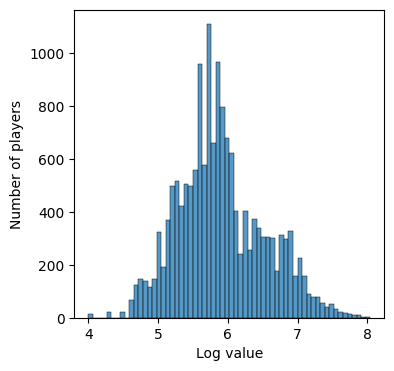

In [11]:
df['log_value_euro'] = np.log10(df['value_euro'])

# Predicted variable
plt.figure(figsize = (4, 4))
sns.histplot(df['log_value_euro'])
plt.ylabel('Number of players')
plt.xlabel('Log value')

### 3.4. Lilliefors test on monovariate description of players value (normal distribution ?)

In [12]:
from statsmodels.stats.diagnostic import lilliefors

lilliefors(df['log_value_euro'], dist='norm')

(np.float64(0.0831777919495007), np.float64(0.0009999999999998899))

This very low p-value (p = 0.0009 < 0.001) for the Lilliefors test means that log(value_euro) do not fit a normal distribution. It would have be interesting to find a normal law, unfortunately it's not the case.

## 4. Data standardization

In [13]:
# Separate X and y
y_column = 'value_euro'
y_log_column = 'log_value_euro'
X_column = [col for col in df.columns if col not in [y_column, y_log_column]]

# Standard scale
scaler = StandardScaler()
df[X_column] = scaler.fit_transform(df[X_column])
#df[df.columns] = scaler.fit_transform(df[df.columns])

display(df)

,age,height_cm,weight_kgs,overall_rating,potential,value_euro,wage_euro,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),...,marking_squared,marking_sqrt,marking_log,standing_tackle_squared,standing_tackle_sqrt,standing_tackle_log,sliding_tackle_squared,sliding_tackle_sqrt,sliding_tackle_log,log_value_euro
0,1.116036,-0.337486,-0.453217,3.943270,3.695997,110500000.0,24.934965,9.814839,1.599125,2.174225,...,-0.862500,-0.561742,-0.387262,-1.014627,-0.794621,-0.636480,-1.009886,-0.824917,-0.679183,8.043362
1,0.277962,-1.422554,0.124916,3.095399,2.885218,69500000.0,8.774430,4.765659,3.106676,2.174225,...,0.479434,0.618684,0.620649,0.255242,0.492989,0.539673,-1.113476,-1.059425,-0.954351,7.841985
2,-0.141074,1.109271,1.210678,3.095399,3.209530,73000000.0,11.018948,7.290249,1.599125,3.484011,...,0.753206,0.774793,0.734440,0.894041,0.855336,0.807122,1.047345,0.946409,0.880031,7.863323
3,0.277962,-0.880020,-2.300422,3.095399,2.723062,62000000.0,6.978815,4.765659,1.599125,2.174225,...,-0.014254,0.289704,0.367883,-1.121781,-1.018422,-0.891534,-1.113476,-1.059425,-0.954351,7.792392
4,0.277962,0.928427,1.915718,3.095399,3.209530,60000000.0,5.632103,4.765659,0.091574,-0.445345,...,3.172277,1.751361,1.372331,2.570887,1.536950,1.258233,2.709100,1.601847,1.310299,7.778151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17949,-0.141074,0.024203,-0.072495,0.127853,-0.195740,975000.0,-0.293427,-0.283521,0.091574,0.864440,...,-0.575824,-0.208213,-0.053555,-1.212449,-1.261791,-1.193200,-1.199801,-1.316415,-1.284891,5.989005
17950,-0.560111,0.566737,0.632545,-1.002641,-0.682207,190000.0,-0.383207,-0.283521,0.091574,-0.445345,...,0.102436,0.374236,0.434610,0.691583,0.749655,0.731326,0.567702,0.694234,0.698268,5.278754
17951,-0.769629,0.747582,2.042625,-1.002641,-0.682207,170000.0,-0.383207,-0.283521,-2.923529,-1.755130,...,-1.427997,-2.234666,-2.641124,-1.344330,-1.836531,-2.038402,-1.283428,-1.682057,-1.820921,5.230449
17952,-0.979148,0.024203,-1.468475,-1.002641,-0.033584,280000.0,-0.248536,-0.283521,1.599125,0.864440,...,-1.329820,-1.625125,-1.643041,-1.251601,-1.392640,-1.367527,-1.218684,-1.385019,-1.379042,5.447158


## 5. Modelling

### 5.0 Train/test split

In [14]:
# Splitting the dataset into train and test
X = df.drop(['value_euro', 'log_value_euro'], axis = 1)
y = df['value_euro']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 666)

### 5.1. Linear regression

#### 5.1.1. Train

In [15]:
# Training Linear Regression
reg = LinearRegression()
reg.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [16]:
# Evaluate the error of the linear regression
y_pred = reg.predict(X_train)

# Compute the rooted mean square error
train_rmse1 = np.sqrt(mean_squared_error(y_train, y_pred))
print("Train RMSE :", train_rmse1)

Train RMSE : 439168.1299690528


#### 5.1.2. Test

In [17]:
# Test the linear regression
y_pred = reg.predict(X_test)

# Compute the rooted mean square error
test_rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE :", test_rmse1)

Test RMSE : 493034.5416910655


Text(0, 0.5, 'Predicted value')

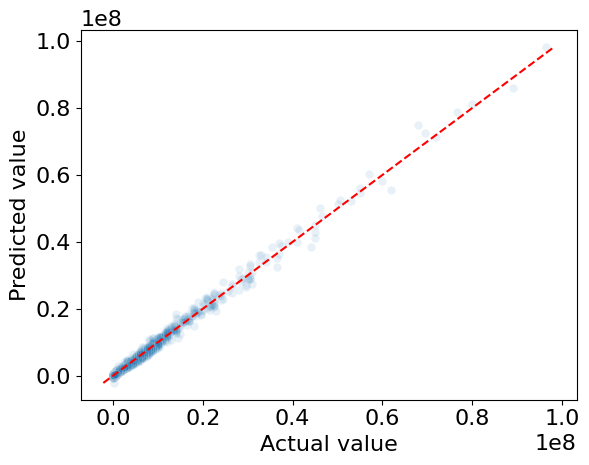

In [18]:
plt.rcParams.update({'font.size':16})
sns.scatterplot(x = y_test, y = y_pred, alpha = 0.1)
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], linestyle='--', color='red')
plt.xlabel("Actual value")
plt.ylabel("Predicted value")

In [19]:
# Store the result for the final panel
y_test1 = y_test
y_pred1 = y_pred

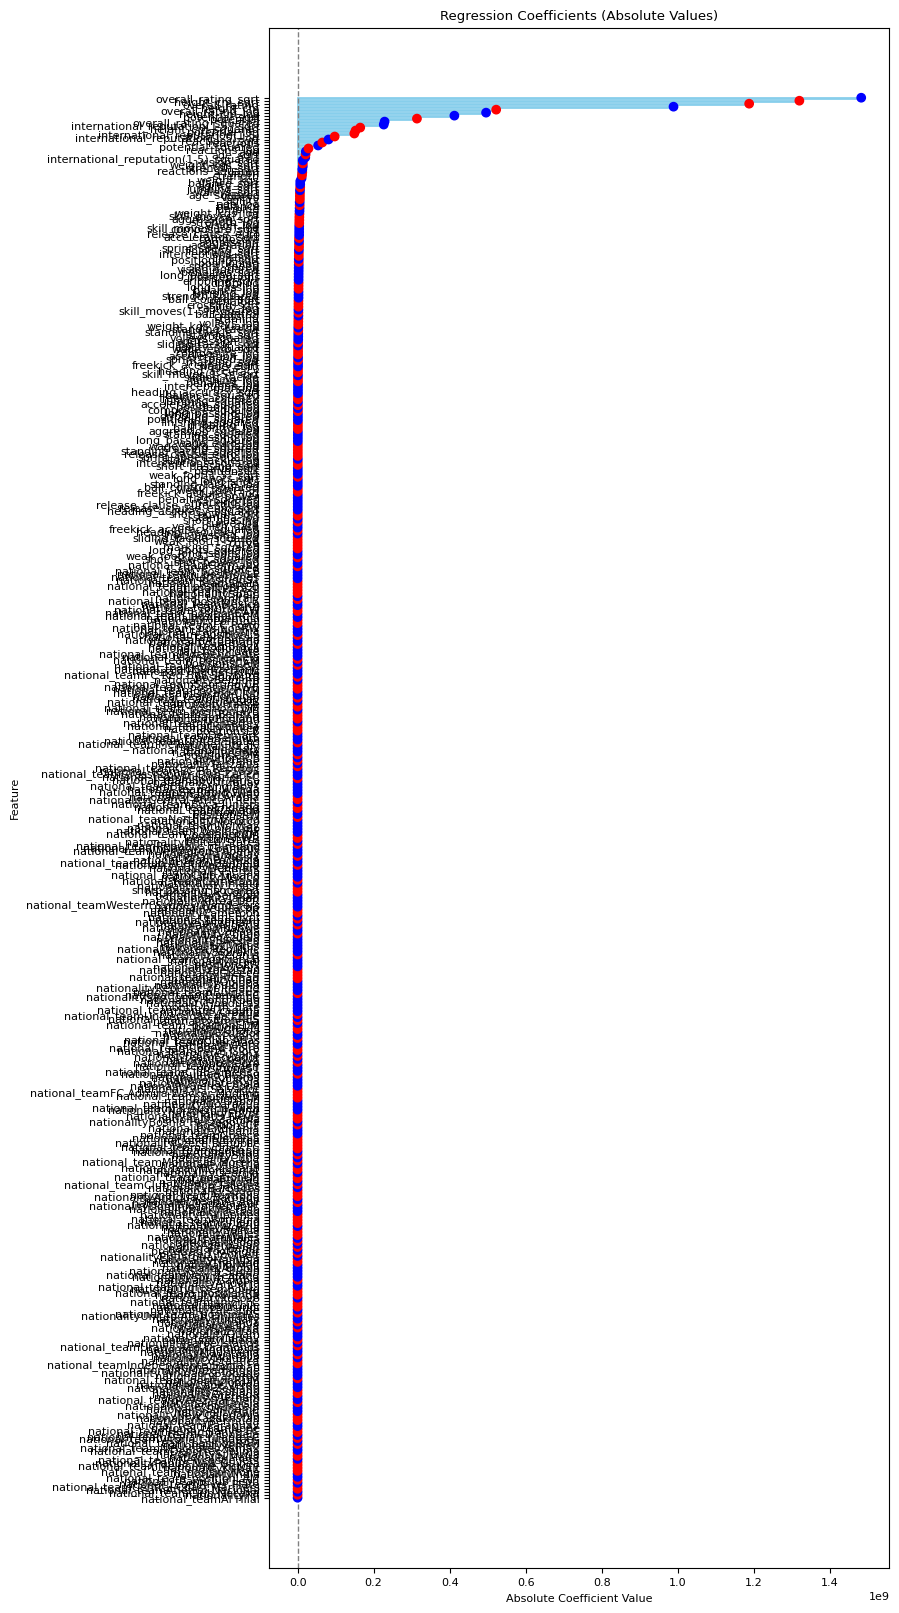

In [20]:
# Linear Regression Model Summary using sklearn
coef = pd.Series(reg.coef_, index = X.columns)
plt.rcParams.update({'font.size': 8})
plot_coef(coef, 8, 20)

### 5.2. LASSO regression

#### 5.2.1. Example of train

In [21]:
# Training LASSO Regression
reg = Lasso(alpha = 0.1)
reg.fit(X_train, y_train)

c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.361e+15, tolerance: 3.896e+13
  model = cd_fast.enet_coordinate_descent(


,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.1
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=1000The maximum number of iterations.",1000
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``, see Notes below.",0.0001
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fit asinitialization, otherwise, just erase the previous solution.See :term:`the Glossary `.",False
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.",False
,"random_state random_state: int, RandomState instance, default=NoneThe seed of the pseudo random number generator that selects a randomfeature to update. Used when ``selection`` == 'random'.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"selection selection: {'cyclic', 'random'}, default='cyclic'If set to 'random', a random coefficient is updated every iterationrather than looping over features sequentially by default. This(setting to 'random') often leads to significantly faster convergenceespecially when tol is higher than 1e-4.",'cyclic'


In [22]:
# Evaluate the error of the LASSO regression
y_pred = reg.predict(X_train)

# Compute the rooted mean square error
print("Train RMSE :", np.sqrt(mean_squared_error(y_train, y_pred)))

Train RMSE : 474549.2903435051


#### 5.2.2. Example of test

In [23]:
# Test the LASSO regression
y_pred = reg.predict(X_test)

# Compute the rooted mean square error
print("Test RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))

Test RMSE : 532903.0315917868


#### 5.2.3. Hyperparameter optimization

In [24]:
# Pipeline
pipe = Pipeline([
    ('lasso', Lasso(max_iter = 10000))
])

# Hyperparameters grid
param_grid = {
    'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
}

# GridSearch 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, verbose = 1)

In [25]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+15, tolerance: 3.896e+13
  model = cd_fast.enet_coordinate_descent(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...iter=10000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'lasso__alpha': [0.001, 0.005, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : 

In [26]:
# Best hyperparameters
print("Optimized parameters :", grid.best_params_)

# Optimized model
best_model = grid.best_estimator_

# Train error
y_pred = best_model.predict(X_train)
train_rmse2 = np.sqrt(mean_squared_error(y_train, y_pred))
print("Optimized train RMSE :", train_rmse2)

# Test error
y_pred = best_model.predict(X_test)
test_rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))
print("Optimized test RMSE :", test_rmse2)

Optimized parameters : {'lasso__alpha': 0.001}
Optimized train RMSE : 467712.69416327024
Optimized test RMSE : 527198.1288674868


Text(0, 0.5, 'Predicted value')

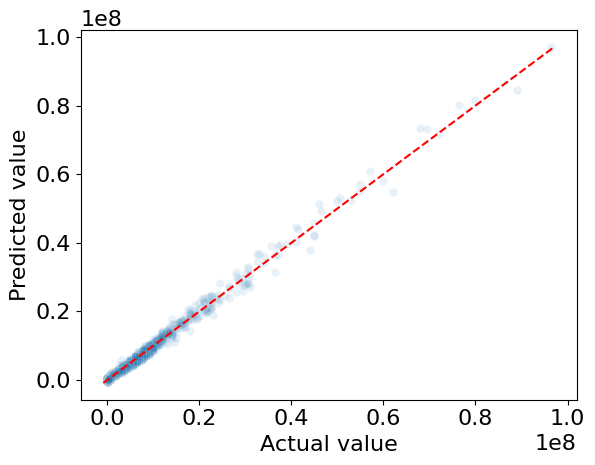

In [27]:
plt.rcParams.update({'font.size':16})
sns.scatterplot(x = y_test , y = y_pred, alpha = 0.1)
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], linestyle='--', color='red')
plt.xlabel("Actual value")
plt.ylabel("Predicted value")

In [28]:
# Store the result for the final panel
y_test2 = y_test
y_pred2 = y_pred

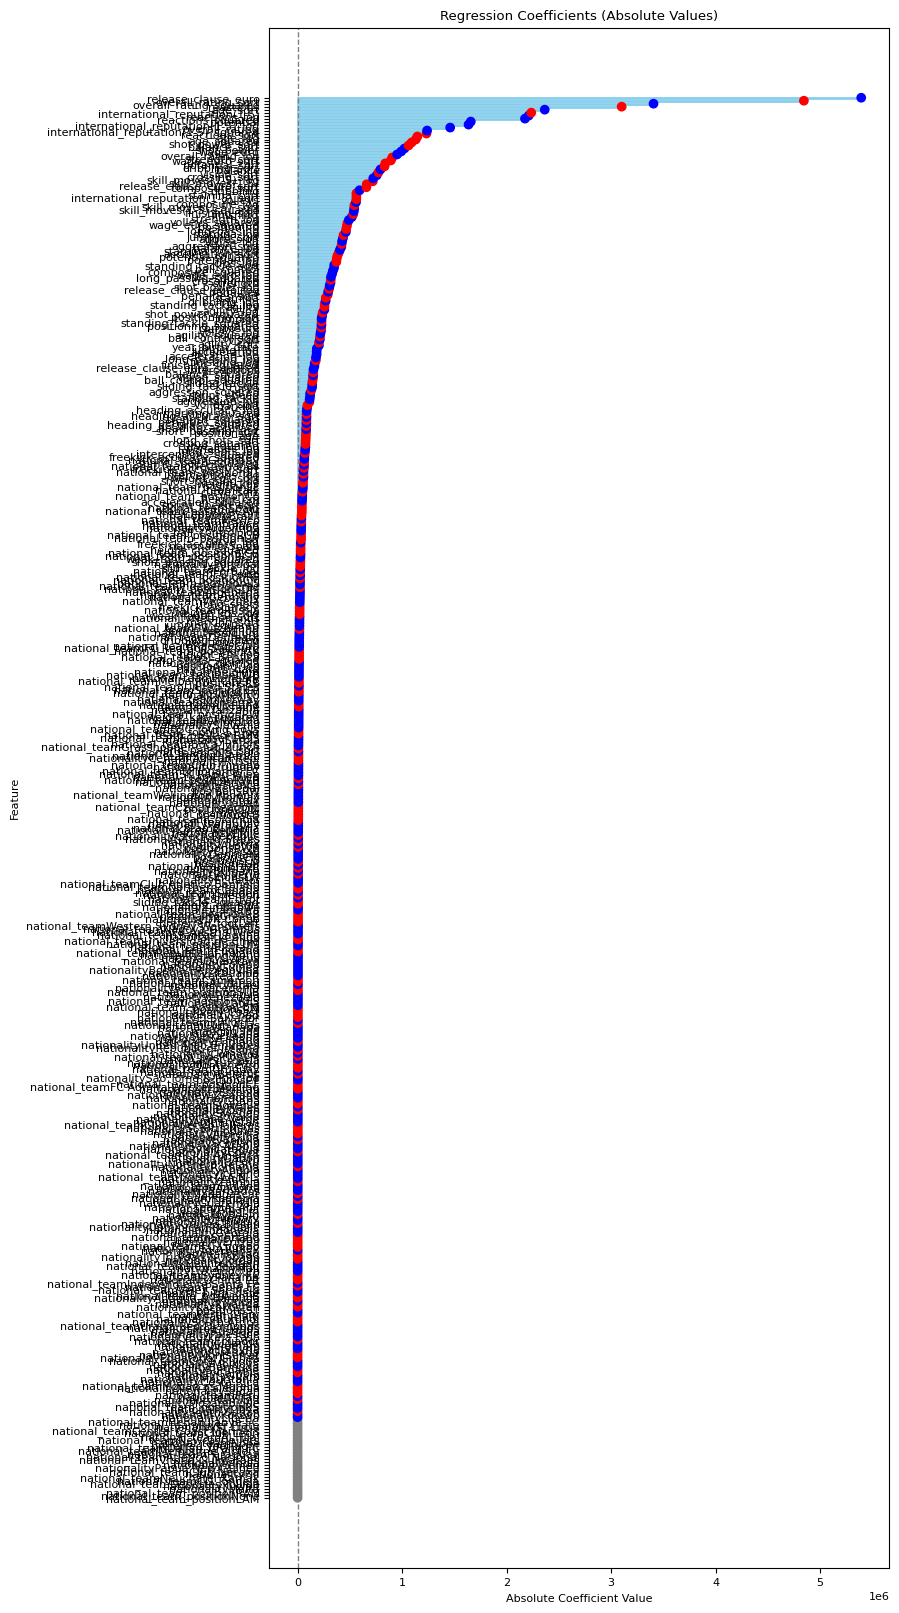

In [29]:
# LASSO Regression Model Summary using sklearn
coef = pd.Series(best_model.named_steps['lasso'].coef_, index = X.columns)
plt.rcParams.update({'font.size':8})
plot_coef(coef, 8, 20)

### 5.3. Neural Network regression

#### 5.3.1. Example of train

In [30]:
# Neural Network constructioon
reg = MLPRegressor(
    hidden_layer_sizes = (16, 8),    # two hidden layers with 16 and 8 neurons
    activation = 'relu',
    solver = 'adam',
    max_iter = 500,
    learning_rate_init = 0.01,
    early_stopping = True,
    batch_size = 64,
    random_state = 666
)

# Train
reg.fit(X_train, y_train)

,"loss loss: {'squared_error', 'poisson'}, default='squared_error'The loss function to use when training the weights. Note that the""squared error"" and ""poisson"" losses actually implement""half squares error"" and ""half poisson deviance"" to simplify thecomputation of the gradient. Furthermore, the ""poisson"" loss internally usesa log-link (exponential as the output activation function) and requires``y >= 0``... versionchanged:: 1.7 Added parameter `loss` and option 'poisson'.",'squared_error'
,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(16, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the regressor will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",64
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate ``learning_rate_`` at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when solver='sgd'.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.01
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",500
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True


In [31]:
# Evaluate the error of the NN regression
y_pred = reg.predict(X_train)

# Compute the rooted mean square error
print("Train RMSE :", np.sqrt(mean_squared_error(y_train, y_pred)))

Train RMSE : 2048687.361377004


#### 5.3.2. Example of test

In [32]:
# Test the NN regression
y_pred = reg.predict(X_test)

# Compute the rooted mean square error
print("Test RMSE :",np.sqrt(mean_squared_error(y_test, y_pred)))

Test RMSE : 2380430.8795303465


#### 5.3.3. Parmeter optimization

In [33]:
# Pipeline
pipe = Pipeline([
    ('mlp', MLPRegressor(max_iter = 500, random_state = 666))
])

# Hyperparameters grid
param_grid = {
    'mlp__hidden_layer_sizes': [(1,), (2,), (2,2), (4,2), (8,4)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__early_stopping': [True],
    'mlp__batch_size': [32, 64]
}

# GridSearch 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs = -2, verbose = 1)

In [34]:
# Train
grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._state=666))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'mlp__activation': ['relu', 'tanh', ...], 'mlp__batch_size': [32, 64], 'mlp__early_stopping': [True], 'mlp__hidden_layer_sizes': [(1,), (2,), ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-2
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 

In [35]:
# Best hyperparameters
print("Optimized parameters :", grid.best_params_)

# Optimized model
best_model = grid.best_estimator_

# Train error
y_pred = best_model.predict(X_train)
train_rmse3 = np.sqrt(mean_squared_error(y_train, y_pred))
print("Optimized train RMSE :", train_rmse3)

# Test error
y_pred = best_model.predict(X_test)
test_rmse3 = np.sqrt(mean_squared_error(y_test, y_pred))
print("Optimized test RMSE :", test_rmse3)

Optimized parameters : {'mlp__activation': 'relu', 'mlp__batch_size': 64, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (4, 2), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Optimized train RMSE : 2107726.502493543
Optimized test RMSE : 2403101.0462890556


Text(0, 0.5, 'Predicted value')

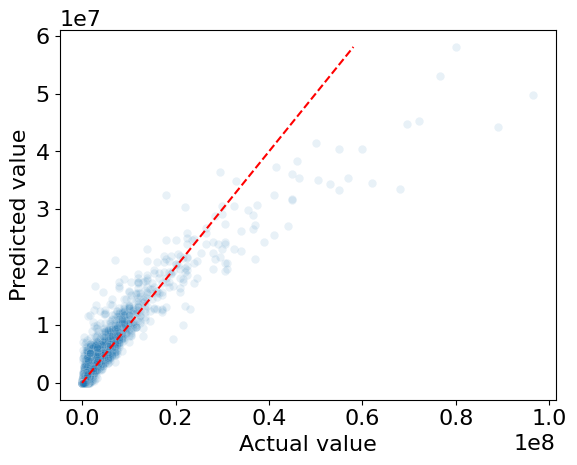

In [36]:
plt.rcParams.update({'font.size':16})
sns.scatterplot(x = y_test, y = y_pred, alpha = 0.1)
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], linestyle='--', color='red')
plt.xlabel("Actual value")
plt.ylabel("Predicted value")

In [37]:
# Store the result for the final panel
y_test3 = y_test
y_pred3 = y_pred

#### 5.3.4. Loss curve of the Neural Network

In [38]:
# Retrieve the best hyperparameters found by GridSearchCV
best_params = grid.best_params_

# Recreate the model using the best parameters
mlp_best = MLPRegressor(
    **{k.replace('mlp__', ''): v for k, v in best_params.items()},
    max_iter = 1,           # Train one iteration at a time
    warm_start = True,      # Keep weights between iterations
    random_state = 666
)

n_iter = 500
train_loss, test_loss = [], []

for iteration in range(n_iter):
    mlp_best.fit(X_train, y_train)
    train_loss.append(np.sqrt(mlp_best.loss_))
    y_test_pred = mlp_best.predict(X_test)
    test_loss.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization

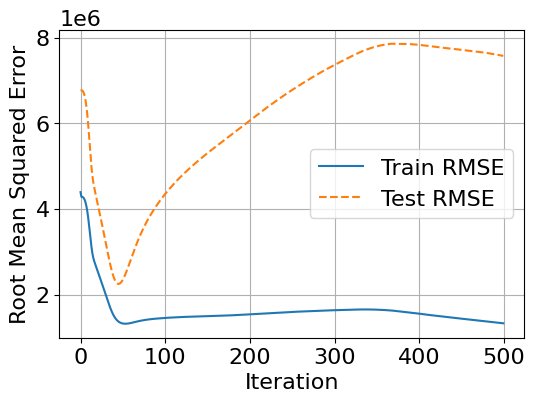

In [39]:
# Plot training vs test error
plt.figure(figsize=(6,4))
plt.plot(train_loss, label='Train RMSE')
plt.plot(test_loss, '--', label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

#### 5.4 Summarizing each model

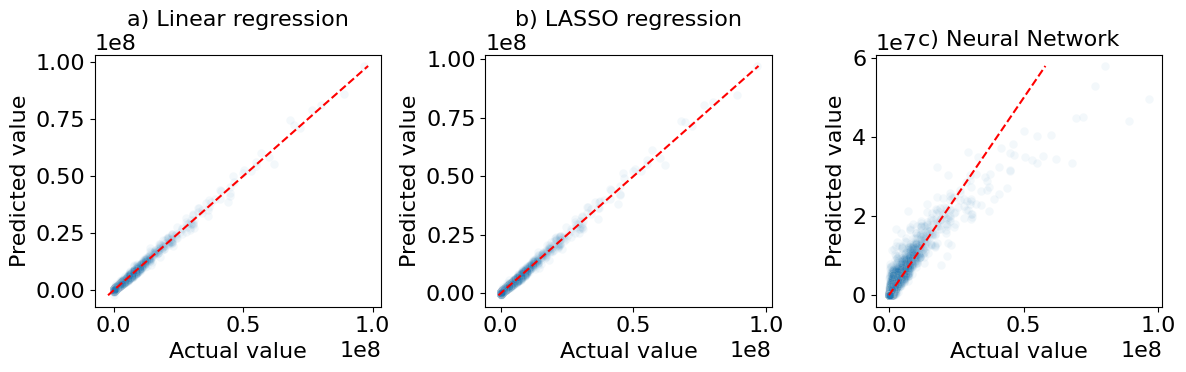

In [40]:
plt.rcParams.update({
    'font.size': 16,          # Taille générale du texte
    'axes.titlesize': 16,     # Taille des titres
    'axes.labelsize': 16,     # Taille des labels
})

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Figure a)
sns.scatterplot(x=y_test1, y=y_pred1, alpha=0.05, ax=axes[0])
axes[0].plot([min(y_pred1), max(y_pred1)], [min(y_pred1), max(y_pred1)], linestyle='--', color='red')
axes[0].set_xlabel("Actual value")
axes[0].set_ylabel("Predicted value")
axes[0].set_title("a) Linear regression")

# Figure b)
sns.scatterplot(x=y_test2, y=y_pred2, alpha=0.05, ax=axes[1])
axes[1].plot([min(y_pred2), max(y_pred2)], [min(y_pred2), max(y_pred2)], linestyle='--', color='red')
axes[1].set_xlabel("Actual value")
axes[1].set_ylabel("Predicted value")
axes[1].set_title("b) LASSO regression")

# Figure b)
sns.scatterplot(x=y_test3, y=y_pred3, alpha=0.05, ax=axes[2])
axes[2].plot([min(y_pred3), max(y_pred3)], [min(y_pred3), max(y_pred3)], linestyle='--', color='red')
axes[2].set_xlabel("Actual value")
axes[2].set_ylabel("Predicted value")
axes[2].set_title("c) Neural Network")

plt.tight_layout()
plt.show()

In [41]:
print("---- RESULTS FOR VALUE ----")

print("---- Linear regression ----")
print(f"Train RMSE : {train_rmse1}")
print(f"Test RMSE : {test_rmse1}")
print("")
print("---- LASSO regression ----")
print(f"Train RMSE : {train_rmse2}")
print(f"Test RMSE : {test_rmse2}")
print("")
print("---- Neural Network ----")
print(f"Train RMSE : {train_rmse3}")
print(f"Test RMSE : {test_rmse3}")

---- RESULTS FOR VALUE ----
---- Linear regression ----
Train RMSE : 439168.1299690528
Test RMSE : 493034.5416910655

---- LASSO regression ----
Train RMSE : 467712.69416327024
Test RMSE : 527198.1288674868

---- Neural Network ----
Train RMSE : 2107726.502493543
Test RMSE : 2403101.0462890556


## 6. Modelling (with log value)

### 6.0 Train/test split

In [42]:
# Splitting the dataset into train and test
X = df.drop(['value_euro', 'log_value_euro'], axis = 1)
y = df['log_value_euro']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 666)

### 6.1. Linear regression

#### 6.1.1. Train

In [43]:
# Training Linear Regression
reg = LinearRegression()
reg.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [44]:
# Evaluate the error of the linear regression
y_pred = reg.predict(X_train)

# Compute the rooted mean square error
train_rmse1 = np.sqrt(mean_squared_error(y_train, y_pred))
print("Train RMSE :", train_rmse1)

Train RMSE : 0.03431004983196644


#### 6.1.2. Test

In [45]:
# Test the linear regression
y_pred = reg.predict(X_test)

# Compute the rooted mean square error
test_rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE :", test_rmse1)

Test RMSE : 0.03703757609844787


In [46]:
# Store the result for the final panel
y_test1 = y_test
y_pred1 = y_pred

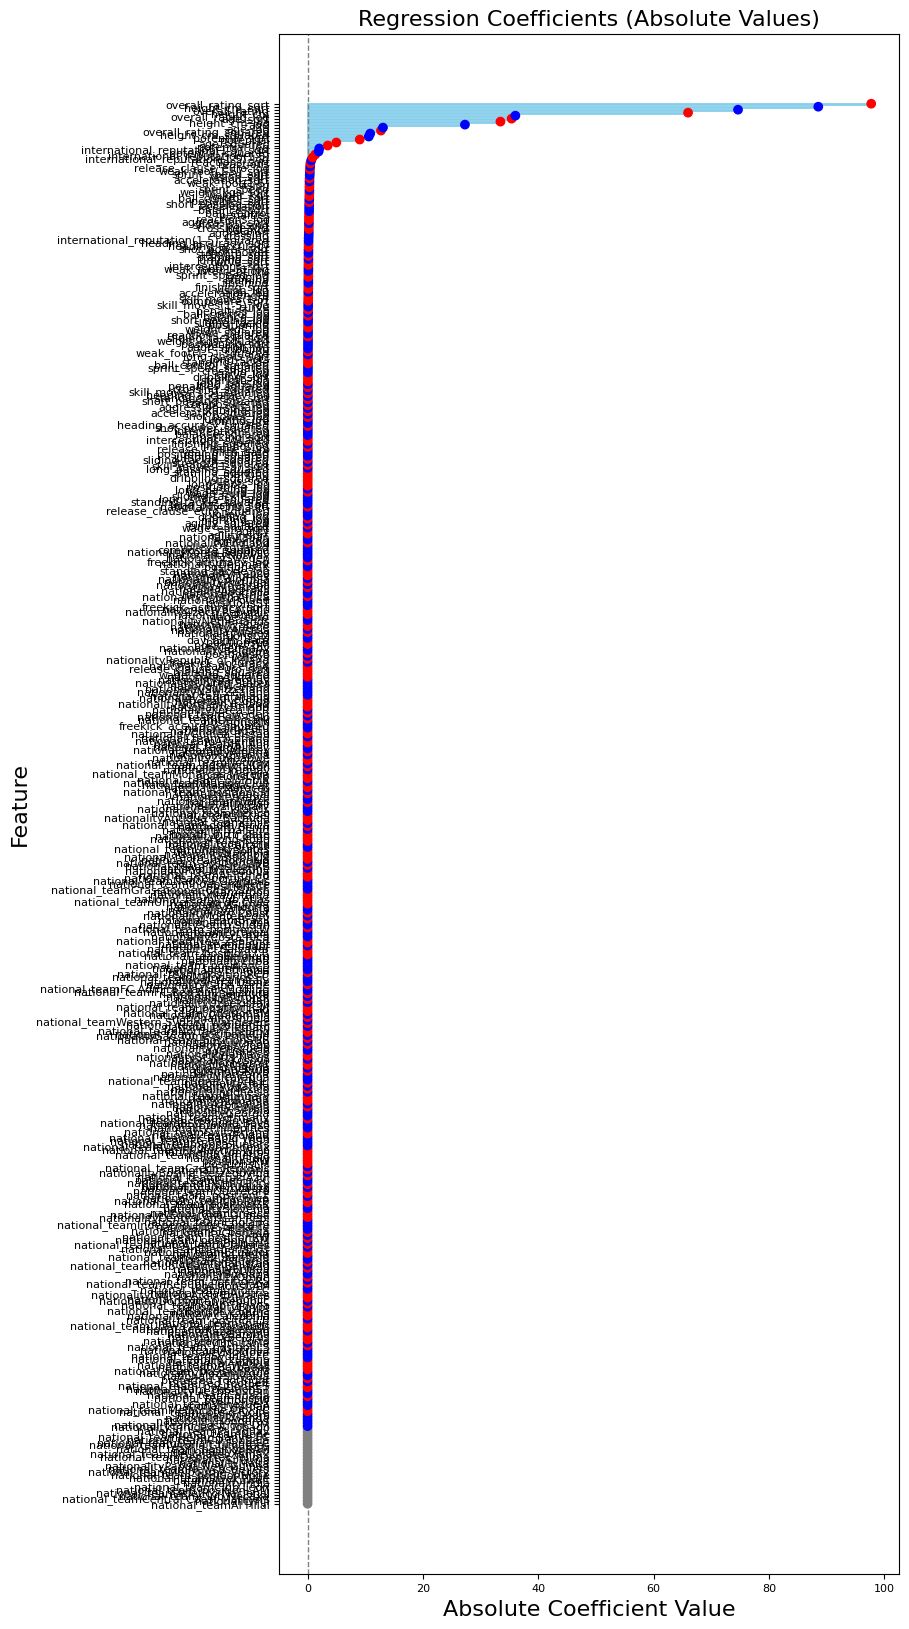

In [47]:
# Linear Regression Model Summary using sklearn
coef = pd.Series(reg.coef_, index = X.columns)
plt.rcParams.update({'font.size': 8})
plot_coef(coef, 8, 20)

### 6.2. LASSO regression

#### 5.2.1. Example of train

In [48]:
# Training LASSO Regression
reg = Lasso(alpha = 0.1)
reg.fit(X_train, y_train)

,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.1
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=1000The maximum number of iterations.",1000
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``, see Notes below.",0.0001
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fit asinitialization, otherwise, just erase the previous solution.See :term:`the Glossary `.",False
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.",False
,"random_state random_state: int, RandomState instance, default=NoneThe seed of the pseudo random number generator that selects a randomfeature to update. Used when ``selection`` == 'random'.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"selection selection: {'cyclic', 'random'}, default='cyclic'If set to 'random', a random coefficient is updated every iterationrather than looping over features sequentially by default. This(setting to 'random') often leads to significantly faster convergenceespecially when tol is higher than 1e-4.",'cyclic'


In [49]:
# Evaluate the error of the LASSO regression
y_pred = reg.predict(X_train)

# Compute the rooted mean square error
print("Train RMSE :", np.sqrt(mean_squared_error(y_train, y_pred)))

Train RMSE : 0.11945524506666634


#### 5.2.2. Example of test

In [50]:
# Test the LASSO regression
y_pred = reg.predict(X_test)

# Compute the rooted mean square error
print("Test RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))

Test RMSE : 0.11880492138980518


#### 5.2.3. Hyperparameter optimization

In [51]:
# Pipeline
pipe = Pipeline([
    ('lasso', Lasso(max_iter = 10000))
])

# Hyperparameters grid
param_grid = {
    'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
}

# GridSearch 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, verbose = 1)

In [52]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...iter=10000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'lasso__alpha': [0.001, 0.005, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : 

In [53]:
# Best hyperparameters
print("Optimized parameters :", grid.best_params_)

# Optimized model
best_model = grid.best_estimator_

# Train error
y_pred = best_model.predict(X_train)
train_rmse2 = np.sqrt(mean_squared_error(y_train, y_pred))
print("Optimized train RMSE :", train_rmse2)

# Test error
y_pred = best_model.predict(X_test)
test_rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))
print("Optimized test RMSE :", test_rmse2)

Optimized parameters : {'lasso__alpha': 0.001}
Optimized train RMSE : 0.03971492017300804
Optimized test RMSE : 0.03976296566159407


In [54]:
# Store the result for the final panel
y_test2 = y_test
y_pred2 = y_pred

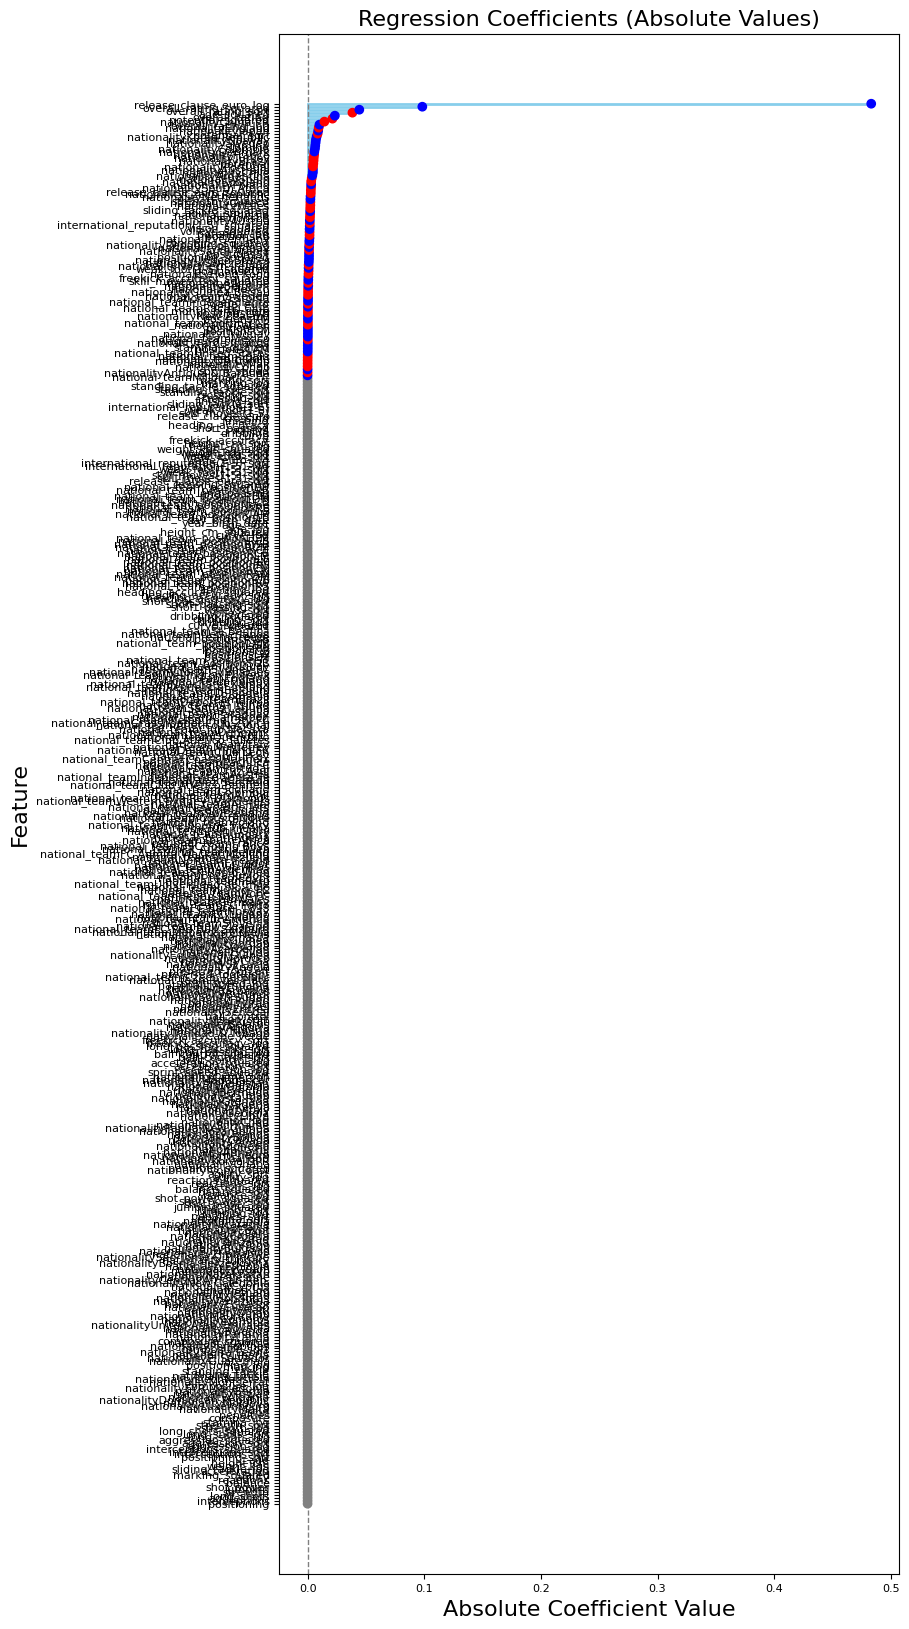

In [55]:
# LASSO Regression Model Summary using sklearn
coef = pd.Series(best_model.named_steps['lasso'].coef_, index = X.columns)
plt.rcParams.update({'font.size':8})
plot_coef(coef, 8, 20)

### 6.3. Neural Network regression

#### 6.3.1. Example of train

In [56]:
# Neural Network constructioon
reg = MLPRegressor(
    hidden_layer_sizes = (16, 8),    # two hidden layers with 16 and 8 neurons
    activation = 'relu',
    solver = 'adam',
    max_iter = 500,
    learning_rate_init = 0.01,
    early_stopping = True,
    batch_size = 64,
    random_state = 666
)

# Train
reg.fit(X_train, y_train)

,"loss loss: {'squared_error', 'poisson'}, default='squared_error'The loss function to use when training the weights. Note that the""squared error"" and ""poisson"" losses actually implement""half squares error"" and ""half poisson deviance"" to simplify thecomputation of the gradient. Furthermore, the ""poisson"" loss internally usesa log-link (exponential as the output activation function) and requires``y >= 0``... versionchanged:: 1.7 Added parameter `loss` and option 'poisson'.",'squared_error'
,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(16, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the regressor will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",64
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate ``learning_rate_`` at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when solver='sgd'.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.01
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",500
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True


In [57]:
# Evaluate the error of the NN regression
y_pred = reg.predict(X_train)

# Compute the rooted mean square error
print("Train RMSE :", np.sqrt(mean_squared_error(y_train, y_pred)))

Train RMSE : 0.057055320670829794


#### 6.3.2. Example of test

In [58]:
# Test the NN regression
y_pred = reg.predict(X_test)

# Compute the rooted mean square error
print("Test RMSE :",np.sqrt(mean_squared_error(y_test, y_pred)))

Test RMSE : 0.06716147773728351


#### 6.3.3. Parmeter optimization

In [59]:
# Pipeline
pipe = Pipeline([
    ('mlp', MLPRegressor(max_iter = 500, random_state = 666))
])

# Hyperparameters grid
param_grid = {
    'mlp__hidden_layer_sizes': [(1,), (2,), (2,2), (4,2), (8,4)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__early_stopping': [True],
    'mlp__batch_size': [32, 64]
}

# GridSearch 5-fold cross-validation
grid = GridSearchCV(pipe, param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs = -2, verbose = 1)

In [60]:
# Train
grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._state=666))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'mlp__activation': ['relu', 'tanh', ...], 'mlp__batch_size': [32, 64], 'mlp__early_stopping': [True], 'mlp__hidden_layer_sizes': [(1,), (2,), ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-2
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 

In [61]:
# Best hyperparameters
print("Optimized parameters :", grid.best_params_)

# Optimized model
best_model = grid.best_estimator_

# Train error
y_pred = best_model.predict(X_train)
train_rmse3 = np.sqrt(mean_squared_error(y_train, y_pred))
print("Optimized train RMSE :", train_rmse3)

# Test error
y_pred = best_model.predict(X_test)
test_rmse3 = np.sqrt(mean_squared_error(y_test, y_pred))
print("Optimized test RMSE :", test_rmse3)

Optimized parameters : {'mlp__activation': 'relu', 'mlp__batch_size': 32, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (8, 4), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Optimized train RMSE : 0.07155364695795581
Optimized test RMSE : 0.08646677062655787


In [62]:
# Store the result for the final panel
y_test3 = y_test
y_pred3 = y_pred

#### 6.3.4. Loss curve of the Neural Network

In [63]:
# Retrieve the best hyperparameters found by GridSearchCV
best_params = grid.best_params_

# Recreate the model using the best parameters
mlp_best = MLPRegressor(
    **{k.replace('mlp__', ''): v for k, v in best_params.items()},
    max_iter = 1,           # Train one iteration at a time
    warm_start = True,      # Keep weights between iterations
    random_state = 666
)

n_iter = 500
train_loss, test_loss = [], []

for iteration in range(n_iter):
    mlp_best.fit(X_train, y_train)
    train_loss.append(np.sqrt(mlp_best.loss_))
    y_test_pred = mlp_best.predict(X_test)
    test_loss.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fares\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization

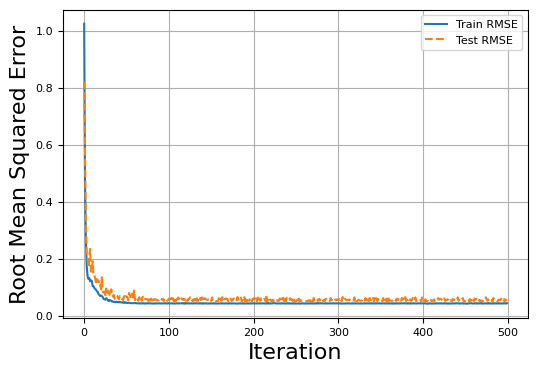

In [64]:
# Plot training vs test error
plt.figure(figsize=(6,4))
plt.plot(train_loss, label='Train RMSE')
plt.plot(test_loss, '--', label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

#### 6.4 Summarizing each model

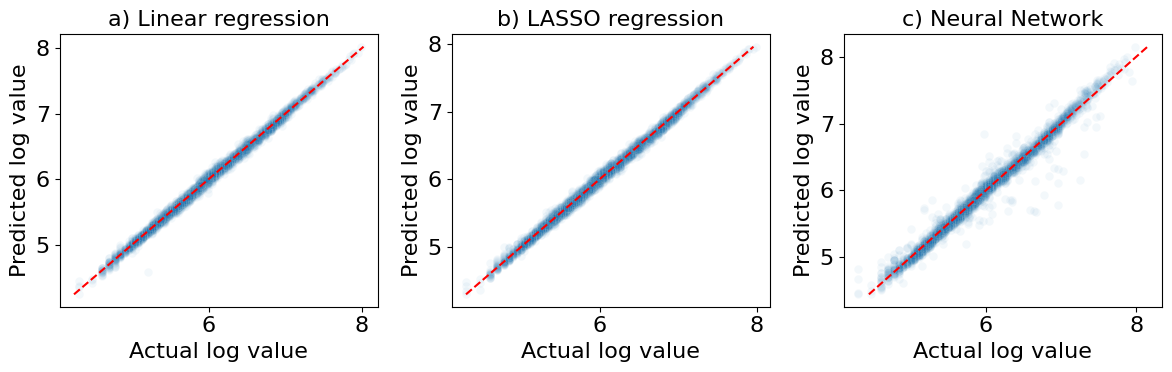

In [65]:
plt.rcParams.update({
    'font.size': 16,          # Taille générale du texte
    'axes.titlesize': 16,     # Taille des titres
    'axes.labelsize': 16,     # Taille des labels
})

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Figure a)
sns.scatterplot(x=y_test1, y=y_pred1, alpha=0.05, ax=axes[0])
axes[0].plot([min(y_pred1), max(y_pred1)], [min(y_pred1), max(y_pred1)], linestyle='--', color='red')
axes[0].set_xlabel("Actual log value")
axes[0].set_ylabel("Predicted log value")
axes[0].set_title("a) Linear regression")

# Figure b)
sns.scatterplot(x=y_test2, y=y_pred2, alpha=0.05, ax=axes[1])
axes[1].plot([min(y_pred2), max(y_pred2)], [min(y_pred2), max(y_pred2)], linestyle='--', color='red')
axes[1].set_xlabel("Actual log value")
axes[1].set_ylabel("Predicted log value")
axes[1].set_title("b) LASSO regression")

# Figure b)
sns.scatterplot(x=y_test3, y=y_pred3, alpha=0.05, ax=axes[2])
axes[2].plot([min(y_pred3), max(y_pred3)], [min(y_pred3), max(y_pred3)], linestyle='--', color='red')
axes[2].set_xlabel("Actual log value")
axes[2].set_ylabel("Predicted log value")
axes[2].set_title("c) Neural Network")

plt.tight_layout()
plt.show()

In [66]:
print("---- RESULTS FOR LOG VALUE ----")

print("---- Linear regression ----")
print(f"Train RMSE : {train_rmse1}")
print(f"Test RMSE : {test_rmse1}")
print("")
print("---- LASSO regression ----")
print(f"Train RMSE : {train_rmse2}")
print(f"Test RMSE : {test_rmse2}")
print("")
print("---- Neural Network ----")
print(f"Train RMSE : {train_rmse3}")
print(f"Test RMSE : {test_rmse3}")

---- RESULTS FOR LOG VALUE ----
---- Linear regression ----
Train RMSE : 0.03431004983196644
Test RMSE : 0.03703757609844787

---- LASSO regression ----
Train RMSE : 0.03971492017300804
Test RMSE : 0.03976296566159407

---- Neural Network ----
Train RMSE : 0.07155364695795581
Test RMSE : 0.08646677062655787


In [68]:
print('Mean values :', np.mean(df['value_euro']), 'Mean log values :', np.mean(df['log_value_euro']))

Mean values : 2465353.0433703545 Mean log values : 5.902173593442068
